# KNN Multi-Class (Mask, No Mask, Incorrect Mask)

## Imports

In [1]:
# import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # to plot inage, graph

import pickle
import time # for computation time assessment
%matplotlib inline

## Prepare Dataset

### Pickle Dataset

In [2]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

pickle_in = open("data.pickle", "rb")
data = pickle.load(pickle_in) # Data Matrix will serve as X

### Dataset Classification Distribution

In [3]:
print('# of Samples:', len(y))
print('# of Without A Mask:', (y == 0).sum())
print('# of Incorrectly Worn Mask:', (y == 1).sum())
print('# of With A Mask:', (y == 2).sum())

# of Samples: 17687
# of Without A Mask: 5909
# of Incorrectly Worn Mask: 5895
# of With A Mask: 5883


### Convert Numpy to Dataframe

In [4]:
# Get Column Names
cols = []
for i in range(0, len(data[0])):
    cols.append("P" + str(i))

# Convert to Dataframe
numpy_data = data
X = pd.DataFrame(data=numpy_data, columns=[cols])
print(X.head())

y = pd.DataFrame(data=y, columns=["Mask_Target"])
print(y.head())

    P0   P1   P2   P3   P4   P5   P6   P7   P8   P9  ... P4086 P4087 P4088  \
0   20   21   19   22   29   31   37   51   54   37  ...   132   131   106   
1  127  127  125  126   87   69   34   30   33   37  ...   141   156   156   
2   48   43   37   34   34   40   49   83  100  106  ...    79    58    41   
3  184   91   63   25   14   17   15   35   44   41  ...    84    86    53   
4  111  125  126   97  109  140  168  185  166   91  ...   138    61    27   

  P4089 P4090 P4091 P4092 P4093 P4094 P4095  
0   158   125    43    24    21    21    34  
1   149   150   149   145   125   115   103  
2    21    14    19    22    23    20    21  
3    17    13    13    14    11    13    15  
4    35    30    38    34    45    54    48  

[5 rows x 4096 columns]
   Mask_Target
0            0
1            0
2            0
3            0
4            0


### Data Shape

In [5]:
# Shape
print('\nImage Data Shape:', X.shape)
print('Image Data Shape Features:', data.shape)
print('Image Data Shape Target:', y.shape)


Image Data Shape: (17687, 4096)
Image Data Shape Features: (17687, 4096)
Image Data Shape Target: (17687, 1)


### Normalize the Data

In [6]:
# Normalize the pixel values
X = X / 255.0

### Split Train + Test, random_state

In [7]:
# Split our data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Print the length and width of our testing data.
print('Length of our Training data: ',len(X_train), '\nLength of our Testing data: ',len(X_test))

Length of our Training data:  14149 
Length of our Testing data:  3538


## KNN No Hyperparameter Tuning

### Build and train KNN model

In [8]:
# Initialize KNN model
knn = KNeighborsClassifier()

%timeit
# Use training data to fit KNN model
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [9]:
%%time
# make prediction on entire test data
predictions_set1 = knn.predict(X_test)

CPU times: user 5min, sys: 94.9 ms, total: 5min
Wall time: 5min


In [10]:
pickle_out = open("predictions_set1.pickle", "wb")
pickle.dump(predictions_set1, pickle_out)
pickle_out.close()

## Performance Metrics for No Hyperparameter Tuning

In [11]:
import seaborn as sns # for confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

#### Accuracy

In [12]:
# 75-82% accuracy depending on the divide
print('KNN Accuracy: %.3f' % accuracy_score(y_test, predictions_set1))

KNN Accuracy: 0.758


#### Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.7577727529677784')

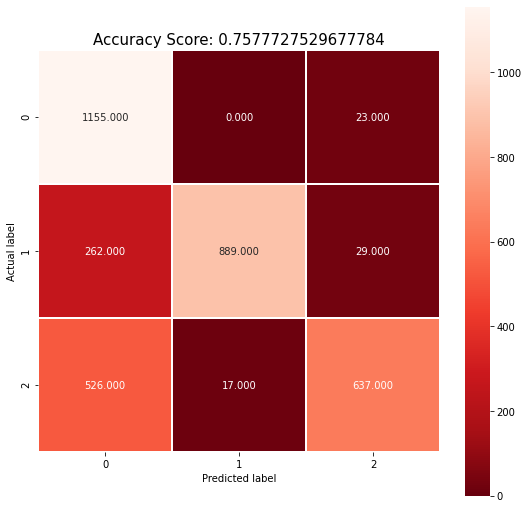

In [13]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, predictions_set1)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions_set1))
plt.title(all_sample_title,size=15)

#### Precision

In [14]:
print('KNN Precision: %.3f' % precision_score(y_test, predictions_set1, average='micro'))

KNN Precision: 0.758


#### Recall

In [15]:
print('KNN Recall: %.3f' % recall_score(y_test, predictions_set1, average='micro'))

KNN Recall: 0.758


#### F1 Score

In [16]:
print('KNN F1 Score: %.3f' % f1_score(y_test, predictions_set1, average='micro'))

KNN F1 Score: 0.758


#### Classification Report

In [17]:
print("\nClassification Report\n", classification_report(y_test, predictions_set1))


Classification Report
               precision    recall  f1-score   support

           0       0.59      0.98      0.74      1178
           1       0.98      0.75      0.85      1180
           2       0.92      0.54      0.68      1180

    accuracy                           0.76      3538
   macro avg       0.83      0.76      0.76      3538
weighted avg       0.83      0.76      0.76      3538



## KNN Hyperparameter Tuning

In [18]:
from sklearn.model_selection import cross_val_score

### GridSearch for Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': [5, 7, 9, 11], 'p': [2, 4, 6, 8, 10, 20, 50], 'metric': ['manhattan', 'mahalanobis']}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, scoring='f1_micro', cv=5, verbose=3, n_jobs=-1)

In [25]:
#fit model to data
# knn_gscv.fit(X_train, y_train.values.ravel())

In [ ]:
#check top performing n_neighbors, p, and distance values
best_params_ = knn_gscv.best_params_

In [ ]:
#check mean score for the top performing value of n_neighbors, p, and distance
knn_gscv.best_score_

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [41]:
#Define the parameter values that should be searched
k_range=list(range(1,21))
metric = ['manhattan']
options=['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, metric=metric, weights=options)

In [42]:
#specify "parameter distribution" rather than "parameter grid"
param_dist = dict(n_neighbors=k_range, metric=metric, weights=options)

In [43]:
#n_iter: Number of random combinations it would try
#random_state: Reproducibility/ Set seed

knn_rand=KNeighborsClassifier()
rand = RandomizedSearchCV(knn_rand, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19,
                                                        20],
                                        'weights': ['uniform', 'distance']},
                   random_state=5, scoring='accuracy')

In [44]:
rand.best_params_

{'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}

In [45]:
rand.best_score_

0.8652206356425648

In [ ]:
# Run prediction on best_score

In [ ]:
# Initial Randomized Search CV result
# 0.7488861511088009
# {'weights': 'distance', 'n_neighbors': 10}
# No real change to accuracy from normalizing the datasets

## Workbook 4 Notes on Mahalanobis Metric

Note: Experimenting with the Mahalanobis Distance Metric¶
Note that we cannot use the Mahalanobis distance metric as a parameter for the grid search.

Because for each iteration of the cross-validation, a new train fold is created which requires to compute the inverse of its covariance matrix.

With the sklearn grid search we cannot compute the inverse of the covariance matrix dynamically for each training fold.

Thus, unfortunately, we can't experiment with the Mahalanobis distance metric using the grid search.

## Test Best Parameters 

In [ ]:
# create new a knn model with best params
knn2 = KNeighborsClassifier(**best_params_)

#fit model to data
knn2.fit(X_train, y_train.values.ravel())

# make prediction on entire test data
predictions_set2 = knn2.predict(X_test)

### Performance Metrics on Best Params

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, predictions_set2)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Greens_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions_set2))
plt.title(all_sample_title,size=15)

print('KNN Precision: %.3f' % precision_score(y_test, predictions_set2, average='micro'))
print('KNN Recall: %.3f' % recall_score(y_test, predictions_set2, average='micro'))
print('KNN F1 Score: %.3f' % f1_score(y_test, predictions_set2, average='micro'))
print("\nClassification Report\n", classification_report(y_test, predictions_set2))

### Saving & Exporting KNN model for future use

In [ ]:
# NAME OF MODEL
filename = 'knn-face-mask-detection-model.pkl'

# EXPORT AND SAVE MODEL 
pickle.dump(knn2, open(filename, 'wb'))